In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
FILE_PATH = './2022_HiMCM_Data_Datetime.xlsx'
FILE_PATH_NON_DATE_INDEX = './2022_HiMCM_Data.xlsx'

CO2_PPM_ANNUALLY = pd.read_excel(FILE_PATH, sheet_name='CO2 Data Set 1', index_col='Year')
CO2_PPM_ANNUALLY_NON_DATE_INDEX = pd.read_excel(FILE_PATH_NON_DATE_INDEX, sheet_name='CO2 Data Set 1', index_col='Year')
TEMPERATURE_ANNUALLY = pd.read_excel(FILE_PATH, sheet_name='Temps Data Set 2', index_col='Year')
TEMPERATURE_ANNUALLY_NON_DATE_INDEX = pd.read_excel(FILE_PATH_NON_DATE_INDEX, sheet_name='Temps Data Set 2', index_col='Year')

CO2_PPM_ANNUALLY.index = CO2_PPM_ANNUALLY.index.to_period('Y')
TEMPERATURE_ANNUALLY.index = TEMPERATURE_ANNUALLY.index.to_period('Y')
TEMPERATURE_ANNUALLY = TEMPERATURE_ANNUALLY[1:]
TEMPERATURE_ANNUALLY_NON_DATE_INDEX = TEMPERATURE_ANNUALLY_NON_DATE_INDEX[1:]
TEMPERATURE_ANNUALLY, CO2_PPM_ANNUALLY

(      Degrees C
 Year           
 1959       0.03
 1960      -0.03
 1961       0.06
 1962       0.03
 1963       0.05
 ...         ...
 2017       0.92
 2018       0.84
 2019       0.97
 2020       1.02
 2021       0.84
 
 [63 rows x 1 columns],
          PPM
 Year        
 1959  315.98
 1960  316.91
 1961  317.64
 1962  318.45
 1963  318.99
 ...      ...
 2017  406.76
 2018  408.72
 2019  411.66
 2020  414.24
 2021  416.45
 
 [63 rows x 1 columns])

<AxesSubplot:xlabel='Year'>

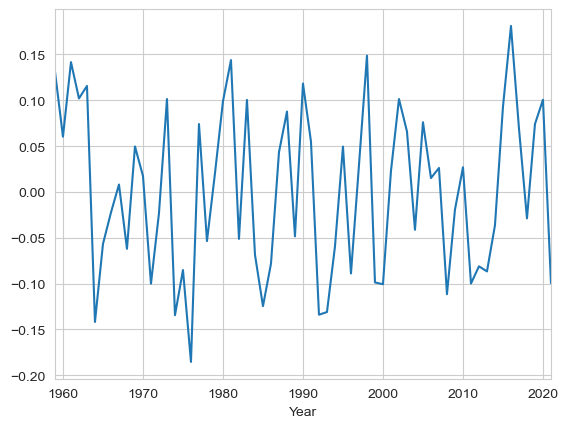

In [19]:
series_original_temps = TEMPERATURE_ANNUALLY['Degrees C']
series_trend_estimated_with_CO2 = 3.77*np.log(CO2_PPM_ANNUALLY['PPM']/324.594)

residuals = series_original_temps - series_trend_estimated_with_CO2
residuals.plot()

In [20]:
from statsmodels.tsa.stattools import adfuller, kpss

ALPHA = 0.05
adf_test = adfuller(residuals)
kpss_test=kpss(residuals)

adf_test[1]>ALPHA, kpss_test[1]<ALPHA

D:\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(False, False)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

AIC_LIST = []
BIC_LIST = []

for p in range(0, 10):
    for q in range(0, 10):
        model = ARIMA(residuals, order=(p,1,q)) # 실제론 d=0이 맞지만, 보고서에서 1로 해두었음
        fitted = model.fit()
        AIC_LIST.append((p, q, fitted.aic))
        BIC_LIST.append((p, q, fitted.bic))

In [22]:
aic_df = pd.DataFrame(AIC_LIST, columns=['p', 'q', 'AIC'])
aic_df = aic_df.set_index(['p', 'q'])['AIC'].unstack()

aic_df

q,0,1,2,3,4,5,6,7,8,9
p,,,,,,,,,,
0,-89.510820,-113.566653,-113.942113,-111.996687,-111.963851,-110.188834,-110.956215,-113.998295,-115.370936,-116.717386
1,-95.324788,-113.581709,-111.974939,-112.255694,-110.123992,-109.132171,-106.535750,-113.850016,-115.848894,-112.787910
2,-101.283950,-112.134477,-110.836462,-116.251698,-117.691451,-117.060716,-117.106540,-113.632827,-114.786441,-114.402945
3,-104.640648,-110.153421,-110.566485,-118.855409,-111.908563,-116.419803,-116.187392,-112.308629,-112.871557,-109.493827
4,-103.494498,-101.854519,-109.469689,-115.783175,-116.569144,-115.898832,-114.403106,-110.931874,-112.252777,-110.516823
5,-103.931165,-116.574873,-115.422016,-117.850390,-118.989206,-114.847420,-113.755365,-112.946259,-111.027245,-112.846338
6,-111.947364,-116.051616,-113.920730,-116.187612,-101.954007,-116.366863,-111.639199,-109.896676,-106.278041,-106.618673
7,-111.804781,-114.847400,-113.096981,-114.989071,-113.637910,-112.296505,-113.471525,-108.218890,-106.466051,-105.178774
8,-109.851847,-112.607354,-114.112851,-112.103108,-112.362002,-110.706167,-108.144426,-109.895764,-109.112090,-104.332879


In [23]:
bic_df = pd.DataFrame(BIC_LIST, columns=['p', 'q', 'BIC'])
bic_df = bic_df.set_index(['p', 'q'])['BIC'].unstack()

bic_df

q,0,1,2,3,4,5,6,7,8,9
p,,,,,,,,,,
0,-87.383686,-109.312384,-107.560710,-103.488149,-101.328179,-97.426028,-96.066275,-96.981220,-96.226727,-95.446042
1,-91.070519,-107.200306,-103.466401,-101.620022,-97.361186,-94.242230,-89.518675,-94.705807,-94.577550,-89.389432
2,-94.902547,-103.625939,-100.200790,-103.488892,-102.801511,-100.043641,-97.962330,-92.361483,-91.387962,-88.877332
3,-96.132110,-99.517749,-97.803679,-103.965469,-94.891488,-97.275594,-94.916048,-88.910151,-87.345944,-81.841080
4,-92.858827,-89.091713,-94.579748,-98.766100,-97.424935,-94.627488,-91.004628,-85.406262,-84.600030,-80.736942
5,-91.168358,-101.684932,-98.404941,-98.706180,-97.717862,-91.448942,-88.229753,-85.293512,-81.247363,-80.939323
6,-97.057423,-99.034541,-94.776520,-94.916268,-78.555529,-90.841251,-83.986452,-80.116794,-74.371025,-72.584523
7,-94.787706,-95.703190,-91.825637,-91.590593,-88.112297,-84.643758,-83.691644,-76.311874,-72.431901,-69.017489
8,-90.707638,-91.336010,-90.714372,-86.577496,-84.709255,-80.926285,-76.237410,-75.861613,-72.950806,-66.044460


Text(0.5, 1.0, 'BIC')

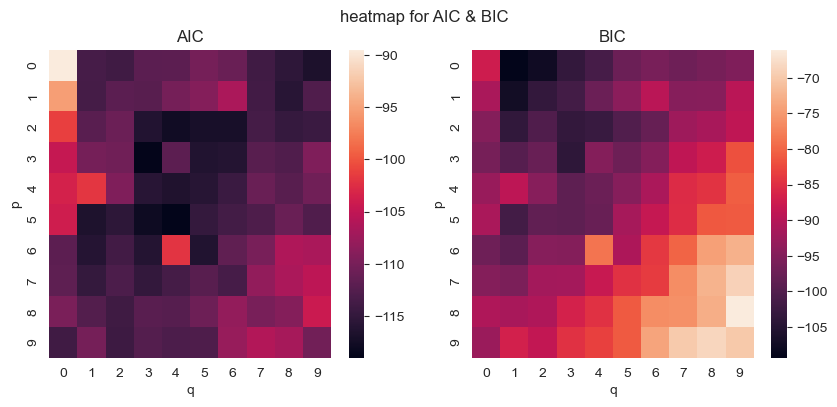

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("heatmap for AIC & BIC")

sns.heatmap(aic_df, ax=axes[0])
axes[0].set_title("AIC")

sns.heatmap(bic_df, ax=axes[1])
axes[1].set_title("BIC")